In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf  # For tf.data
import keras
from keras import layers

import matplotlib.pyplot as plt

In [ ]:
dataset_url = "https://git.io/JiY4i"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

1078925405/1078925405 [==============================] - 14s 0us/step


In [ ]:
with open("/tmp/.keras/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

# Iterate through the items
for key, value in metadata.items():
    print(f"{key}: {value}")

Airplane: {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}
Bag: {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}
Cap: {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}
Car: {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}
Chair: {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}
Earphone: {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}
Guitar: {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}
Knife: {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}
Lamp: {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}
Laptop: {'directory': '03642806', 'lables': ['keyboard'], 'c

In [ ]:
points_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points".format(
    metadata["Table"]["directory"]
)
labels_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points_label".format(
    metadata["Table"]["directory"]
)
LABELS = metadata["Table"]["lables"]
COLORS = metadata["Table"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 2048
BATCH_SIZE = 32

In [ ]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))
for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])
    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        # Apply one-hot encoding to the dense label representation.
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)

100%|██████████| 8509/8509 [01:57<00:00, 72.47it/s]


In [ ]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[7718].shape: (2819, 3)
point_cloud_labels[7718].shape: (2819, 3)
all_labels[7718][0]: none 	point_cloud_labels[7718][0]: [0. 0. 1.] 

all_labels[7718][1]: leg 	point_cloud_labels[7718][1]: [1. 0. 0.] 

all_labels[7718][2]: leg 	point_cloud_labels[7718][2]: [1. 0. 0.] 

all_labels[7718][3]: leg 	point_cloud_labels[7718][3]: [1. 0. 0.] 

all_labels[7718][4]: leg 	point_cloud_labels[7718][4]: [1. 0. 0.] 

point_clouds[6933].shape: (2819, 3)
point_cloud_labels[6933].shape: (2819, 3)
all_labels[6933][0]: leg 	point_cloud_labels[6933][0]: [1. 0. 0.] 

all_labels[6933][1]: leg 	point_cloud_labels[6933][1]: [1. 0. 0.] 

all_labels[6933][2]: top 	point_cloud_labels[6933][2]: [0. 1. 0.] 

all_labels[6933][3]: top 	point_cloud_labels[6933][3]: [0. 1. 0.] 

all_labels[6933][4]: top 	point_cloud_labels[6933][4]: [0. 1. 0.] 

point_clouds[6506].shape: (2819, 3)
point_cloud_labels[6506].shape: (2819, 3)
all_labels[6506][0]: leg 	point_cloud_labels[6506][0]: [1. 0. 0.] 

all_labels[6506][

In [ ]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 7741/7741 [00:48<00:00, 160.93it/s]


In [ ]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.001, 0.001, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch

def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset

In [ ]:
split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 6192
Num train point cloud labels: 6192
Num val point clouds: 1549
Num val point cloud labels: 1549
Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2048, 3), dtype=tf.float32, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2048, 3), dtype=tf.float32, name=None))>


In [ ]:
def conv_block(x, filters, name):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x, filters, name):
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class OrthogonalRegularizer(keras.regularizers.Regularizer):

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super().get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

In [ ]:
def transformation_net(inputs, num_features, name):
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)

def transformation_block(inputs, num_features, name):
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_shape_segmentation_model(num_points, num_classes):
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

        # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

In [ ]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 input_transformation_block  (None, None, 64)             256       ['input_1[0][0]']             
 _1_conv (Conv1D)                                                                                 
                                                                                                  
 input_transformation_block  (None, None, 64)             256       ['input_transformation_block_1
 _1_batch_norm (BatchNormal                                         _conv[0][0]']                 
 ization)                                                                                     

Steps per epoch: 193.
Total training steps: 1930.


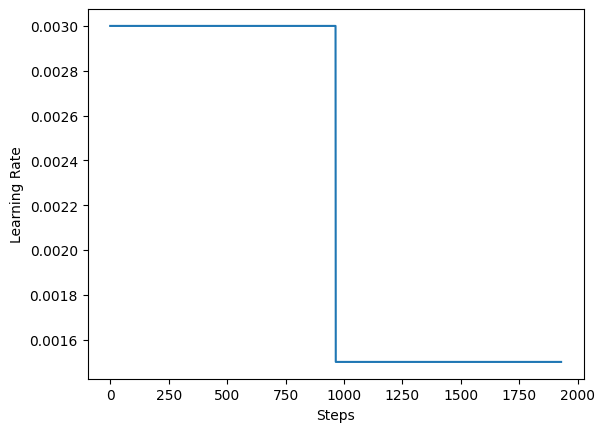

In [ ]:
EPOCHS = 10
INITIAL_LR = 1e-3
steps_per_epoch = total_training_examples // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
def run_experiment(epochs):
    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "checkpoint.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history

segmentation_model, history = run_experiment(epochs=EPOCHS)


Epoch 1/10
194/194 [==============================] - 151s 719ms/step - loss: 19.0614 - accuracy: 0.8134 - val_loss: 329.6665 - val_accuracy: 0.7032
Epoch 2/10
194/194 [==============================] - 142s 732ms/step - loss: 4.5134 - accuracy: 0.8812 - val_loss: 10.2090 - val_accuracy: 0.8059
Epoch 3/10
194/194 [==============================] - 142s 735ms/step - loss: 4.4588 - accuracy: 0.8894 - val_loss: 4.5914 - val_accuracy: 0.8322
Epoch 4/10
194/194 [==============================] - 141s 726ms/step - loss: 4.4689 - accuracy: 0.8903 - val_loss: 4.4643 - val_accuracy: 0.8823
Epoch 5/10
194/194 [==============================] - 142s 734ms/step - loss: 4.4279 - accuracy: 0.8967 - val_loss: 4.3931 - val_accuracy: 0.8971
Epoch 6/10
194/194 [==============================] - 140s 724ms/step - loss: 4.3974 - accuracy: 0.9031 - val_loss: 4.3970 - val_accuracy: 0.8929
Epoch 7/10
194/194 [==============================] - 142s 734ms/step - loss: 4.3913 - accuracy: 0.9046 - val_loss: 4.35

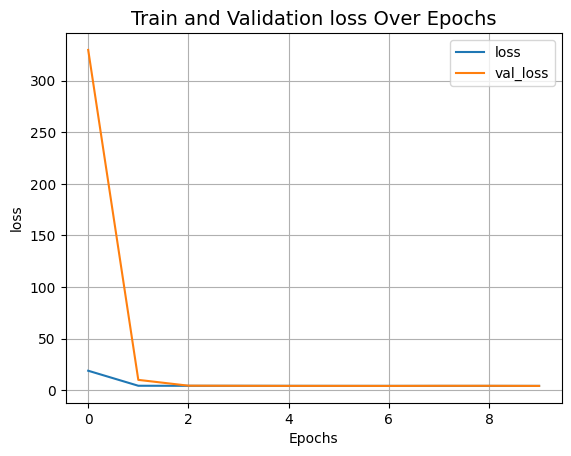

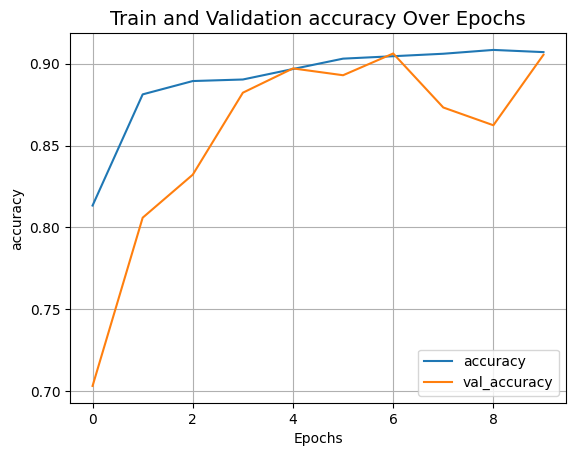

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [ ]:
def visualizeData(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()



1/1 [==============================] - 1s 512ms/step
Validation prediction shape: (32, 2048, 3)
Index selected: 13


<ipython-input-43-1018ad05fa86>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


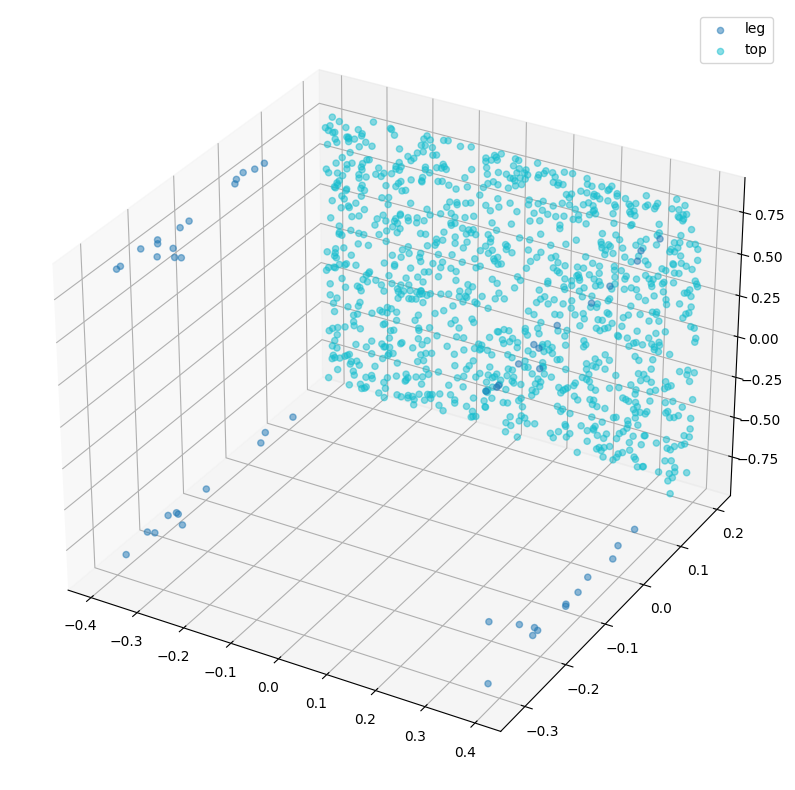

<ipython-input-43-1018ad05fa86>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


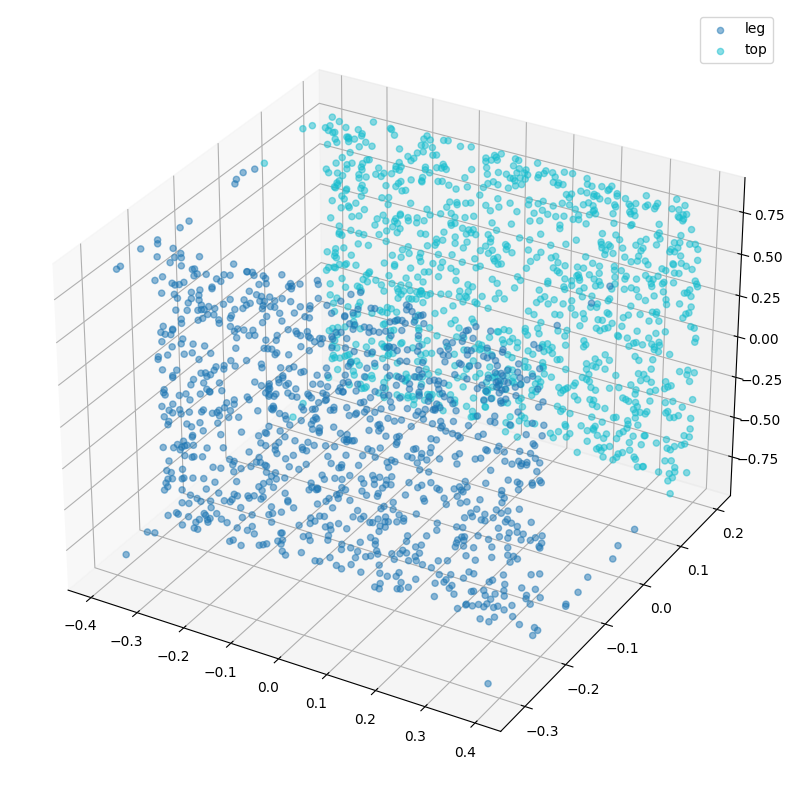

In [ ]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

In [ ]:
def get_shape_classification_model(num_points, num_classes):
    input_points = keras.Input(shape=(None, 3))

    transformed_inputs = transformation_block(
    input_points, num_features=3, name="input_transformation_block")
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block( features_128_2, num_features=128, name="transformed_features")
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Classification head.
    classification_input = layers.Concatenate(name="classification_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    classification_features = conv_block(
        classification_input, filters=128, name="classification_features"
    )
    outputs = layers.Dense(
        num_classes, activation="softmax", name="classification_head"
    )(classification_features)
    return keras.Model(input_points, outputs)


In [ ]:
# Instantiate the classification model
classification_model = get_shape_classification_model(num_points, num_classes)
classification_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 input_transformation_block  (None, None, 64)             256       ['input_2[0][0]']             
 _1_conv (Conv1D)                                                                                 
                                                                                                  
 input_transformation_block  (None, None, 64)             256       ['input_transformation_block_1
 _1_batch_norm (BatchNormal                                         _conv[0][0]']                 
 ization)                                                                                   

In [ ]:
def run_classification_experiment(epochs):
    classification_model = get_shape_classification_model(num_points, num_classes)
    classification_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "classification_checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    classification_history = classification_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    classification_model.load_weights(checkpoint_filepath)
    return classification_model, classification_history


classification_model, classification_history = run_classification_experiment(
    epochs=10
)



Epoch 1/10
194/194 [==============================] - 159s 737ms/step - loss: 13.5326 - accuracy: 0.7841 - val_loss: 31.7075 - val_accuracy: 0.3949
Epoch 2/10
194/194 [==============================] - 142s 730ms/step - loss: 4.5505 - accuracy: 0.8698 - val_loss: 4.9009 - val_accuracy: 0.8537
Epoch 3/10
194/194 [==============================] - 143s 739ms/step - loss: 4.4704 - accuracy: 0.8865 - val_loss: 4.4552 - val_accuracy: 0.8799
Epoch 4/10
194/194 [==============================] - 143s 736ms/step - loss: 4.4457 - accuracy: 0.8927 - val_loss: 4.5292 - val_accuracy: 0.8671
Epoch 5/10
194/194 [==============================] - 144s 744ms/step - loss: 4.4328 - accuracy: 0.8948 - val_loss: 4.4194 - val_accuracy: 0.8958
Epoch 6/10
194/194 [==============================] - 145s 745ms/step - loss: 4.3841 - accuracy: 0.9057 - val_loss: 4.3836 - val_accuracy: 0.8938
Epoch 7/10
194/194 [==============================] - 144s 743ms/step - loss: 4.3789 - accuracy: 0.9079 - val_loss: 4.3582

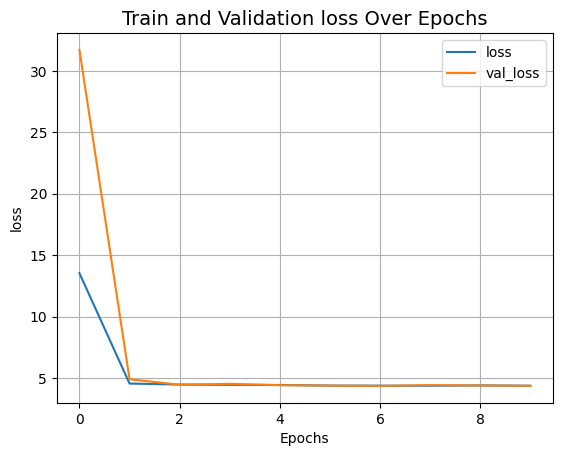

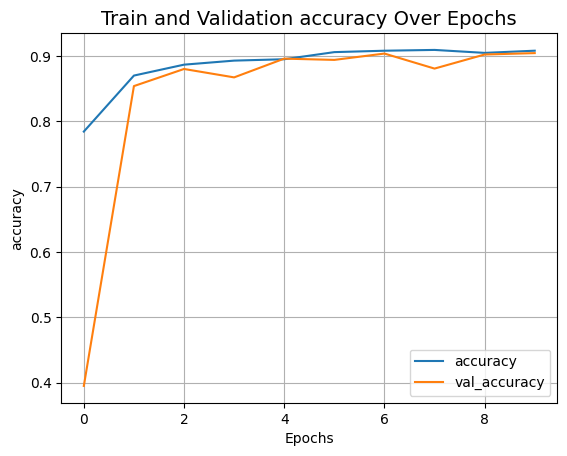

In [ ]:
def plot_classification_result(item):
    plt.plot(classification_history.history[item], label=item)
    plt.plot(classification_history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# Visualize training landscape for classification
plot_classification_result("loss")
plot_classification_result("accuracy")


In [ ]:
def visualize_single_point_cloud1(point_clouds, label_clouds, idx, labels):
    label_map = labels + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


1/1 [==============================] - 0s 27ms/step
Index selected: 18


<ipython-input-43-1018ad05fa86>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


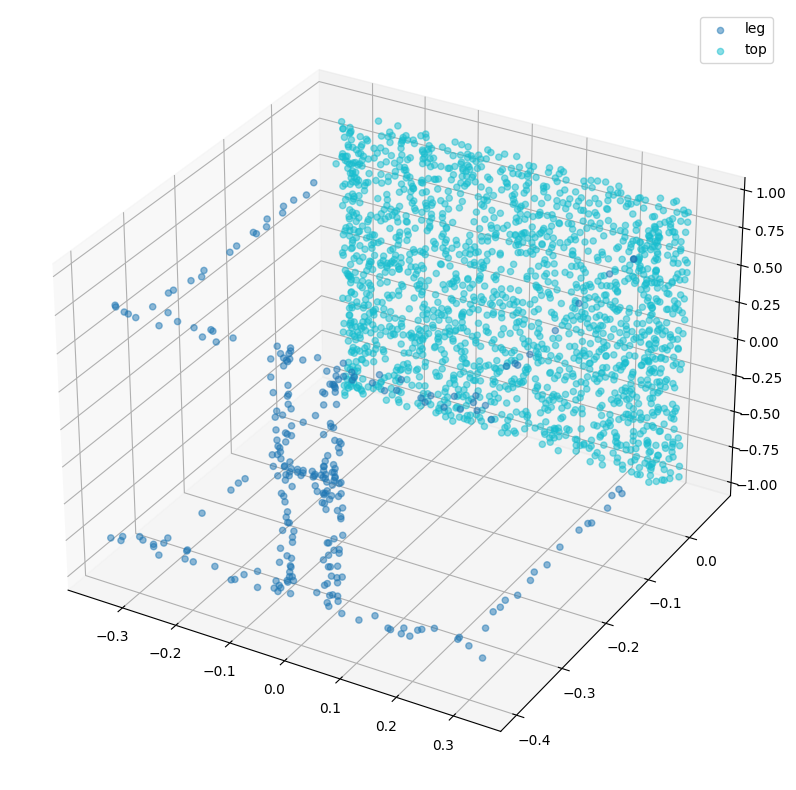

Ground Truth Labels: ['top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'leg', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'top', 'top', 'top', 'top'

<ipython-input-43-1018ad05fa86>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


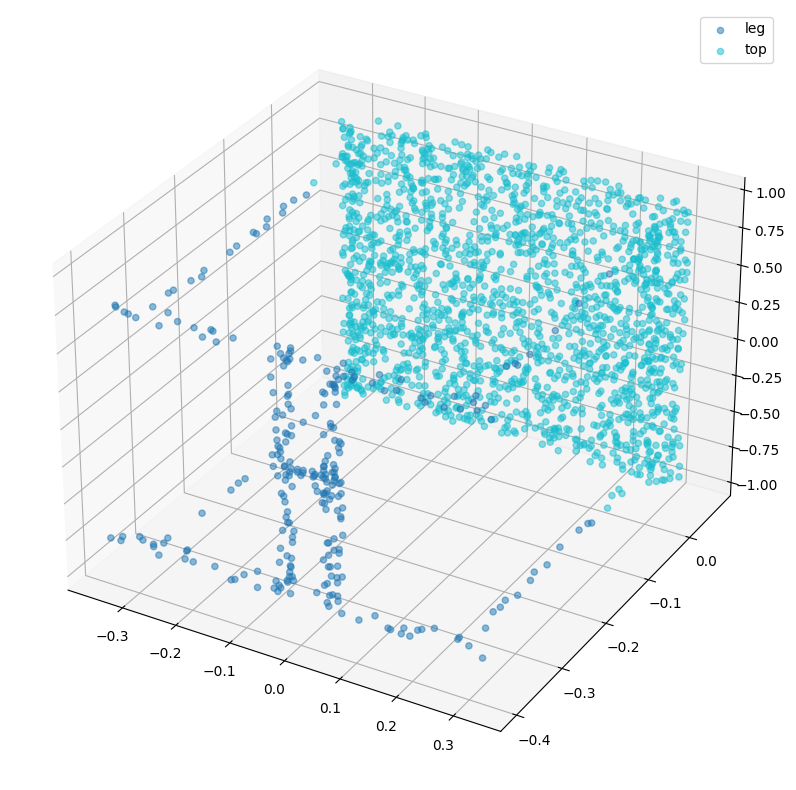

Predicted Labels: ['top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'leg', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'top', 'leg', 'leg', 'top', 'top', 'top', 'top', 'top', '

In [ ]:
validation_batch_classification = next(iter(val_dataset))
val_predictions_classification = classification_model.predict(validation_batch_classification[0])

# Visualize a single point cloud with ground-truth labels and predicted labels
idx_classification = np.random.choice(len(validation_batch_classification[0]))
print(f"Index selected: {idx_classification}")

# Plotting with ground-truth labels
ground_truth_labels = [LABELS[np.argmax(label)] for label in validation_batch_classification[1][idx_classification]]
visualize_single_point_cloud1(validation_batch_classification[0], validation_batch_classification[1], idx_classification, LABELS)
print(f"Ground Truth Labels: {ground_truth_labels}")

# Plotting with predicted labels
predicted_labels = [LABELS[np.argmax(label)] for label in val_predictions_classification[idx_classification]]
visualize_single_point_cloud1(validation_batch_classification[0], val_predictions_classification, idx_classification, LABELS)
print(f"Predicted Labels: {predicted_labels}")


In [ ]:
num_correct = sum(1 for gt, pred in zip(ground_truth_labels, predicted_labels) if gt == pred)
total_predictions = len(ground_truth_labels)

accuracy = (num_correct / total_predictions) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 99.66%


In [ ]:
test_results = classification_model.evaluate(val_dataset)

# Extracting metrics
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


49/49 [==============================] - 9s 175ms/step - loss: 4.3582 - accuracy: 0.9035
Test Loss: 4.3582
Test Accuracy: 90.35%
